# Best Practices - TensorFlow-Keras VGG19 on CIFAR100

## Optimizing VGG19 with NetsPresso Model Compressor
By following this notebook, the user can accelerate (x14.73) and compress (x6.03) the VGG19 with minute performance degradation (-1.15) by using NetsPresso Model Compressor.

 This notebook contains the following 3 parts:

  1. [Model Compression with NetsPresso Model Compressor](#compression)
  2. [Fine-Tuning the Compressed Model](#fine-tuning)
  3. [Performance Comparision](#comparision)

For more details, please visit [Docs](https://docs.netspresso.ai/docs/technology-support-1) and [Netspresso.ai](https://www.netspresso.ai/model-compressor).


<div align="center">
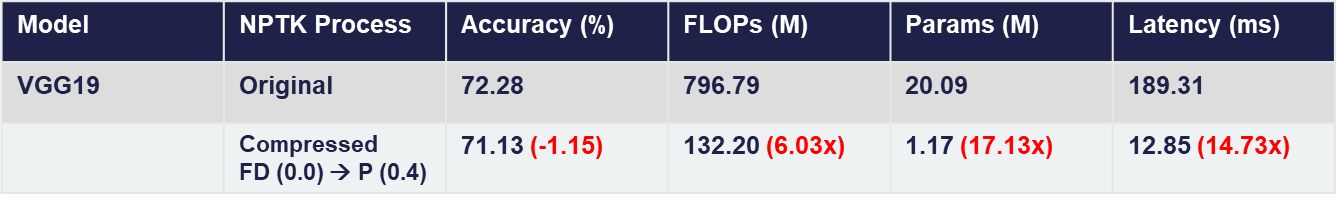
</div>
<div align='center'>
Fig. 1 Compression result of the VGG19. The model's latency is measured using a Raspberry Pi 4B (1.5GHz ARM Cortex).
</div>




<a name="compression"></a>
# 1. Model Compression with NetsPresso Model Compressor

Before starting the best practice, please install the following packages:

In [ ]:
! pip install "tensorflow-gpu==2.3.1"
! pip install "albumentations==0.5.2"
! pip install "opencv-python==4.5.1.48"
! pip install torch
! pip install easydict
! pip install keras-flops

### Preparing the pre-trained VGG19 on CIFAR100 ([link](https://github.com/Nota-NetsPresso/NetsPresso-CompressionToolkit-ModelZoo/blob/main/models/tensorflow/cifar100.md))

In [ ]:
import tensorflow as tf
original_model = tf.keras.models.load_model('vgg19.h5')

Determining device to use

In [ ]:
import os
if tf.test.is_gpu_available():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    print('Using GPU')
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    print('Using CPU')

### **VGG19 compression using NetsPresso Model Compressor**

<a name='compGuide'></a>

__Compression Guide__ 
1. Sign up NetsPresso Model Compressor ([link](https://compression.netspresso.ai/#/login)).
2. Upload the downloaded VGG19.
3. To compress the model and reproduce the best practice result, please select the following compression procedures one by one as depicted [here](#fine-tuning): 
    * `Tucker Decomposition` &rarr; `Recommendation(VBMF):0.0`
    * `L2 Norm Pruning` &rarr; `Recommendation(SLAMP) pruning ratio: 0.4`
4. Press `Compress` button, and get the compressed model. The compression result will be shown as follow.

---
* If it is hard to follow, please refer to the following user-guide video ([link](https://youtu.be/Qy-yaW0vL4k)).

<div align='center'>
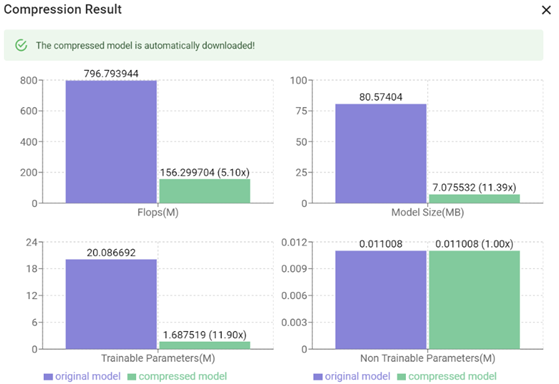
&nbsp; &nbsp; &nbsp; &nbsp;
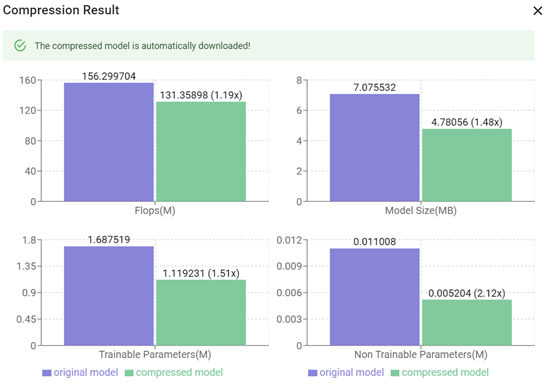
</div>
<div align='center'>
Fig 2. The results of each compression. Left: Tucker Decomposition. Right: L2 Norm Pruning.
</div>


<!-- Fig. 2 NetsPresso Model Compressor provides the comparision of flops, model size, and the number of parameters - Original model(purple) and compressed model(green). 
Please prune the model after fine-tuning the decomposed model. -->

<a name="fine-tuning"></a>
# 2. Fine-tuning the Compressed Model.
Both filter decomposition and structured pruning may induce the performance degradation, which requires additional fine-tuning process. Therefore, the fine-tuning process is necessary to compensate the performance after each compression process.
<!-- This fine-tuning process is required for each of the compression process.  -->

Here, `Filter Decomposition` &rarr; `Fine-tuning` &rarr; `Sturctured Pruning` &rarr; `Fine-tuning`

### Loading the dataset

In [ ]:
import os
import math
import argparse

import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import cv2

from albumentations import Compose, PadIfNeeded, RandomCrop, HorizontalFlip, Normalize

batch_size = 256

# data will be downloaded in data_directory.
class Dataloader(Sequence):
    def __init__(self, x_set, y_set, batch_size, mode = "train", shuffle = True):
        self.x, self.y = x_set, to_categorical(y_set)
        self.batch_size = batch_size
        self.mode = mode
        self.augment = self._set_augmentation()
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def _set_augmentation(self):
        if self.mode == "train":
            img_preprocessor = Compose([
                PadIfNeeded(40, 40, border_mode = cv2.BORDER_CONSTANT, value = 0),
                RandomCrop(32, 32),
                HorizontalFlip(p = 0.5),
                Normalize (mean = (0.4914, 0.4822, 0.4465), std = (0.2023, 0.1994, 0.2010), max_pixel_value = 255.0)
            ])
        elif self.mode == "test":
            img_preprocessor = Compose([
                Normalize (mean = (0.4914, 0.4822, 0.4465), std = (0.2023, 0.1994, 0.2010), max_pixel_value = 255.0)
            ])
        return img_preprocessor

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]

        return np.stack([
            self.augment(image=x)["image"] for x in batch_x
        ], axis=0), np.array(batch_y)

    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar100.load_data()
train_loader = Dataloader(train_x, train_y, batch_size, "train")
test_loader = Dataloader(test_x, test_y, batch_size, "test")

### Fine-tuning the compressed model

Setting the hyperparameters and the path of the model

In [ ]:
import easydict

train_config = easydict.EasyDict({
    # the path of the model to be loaded
    'model_path':'vgg19_compressed1_model.h5',
    # the path of the model to be saved
    'save_path':'finetuned1_vgg19.h5',
    'learning_rate':0.001,
    'epochs':1,
})

Fine-tuning the compressed model 

In [ ]:
class Trainer():
    def __init__(self, train_config):
        self.model = tf.keras.models.load_model(train_config.model_path)
        self.save_path = train_config.save_path
        self.learning_rate = train_config.learning_rate
        self.epochs = train_config.epochs

    def _create_callbacks(self):
        reduce_lr = ReduceLROnPlateau(monitor="val_categorical_accuracy", mode="max", min_delta=0.0001)
        checkpoint = ModelCheckpoint(
                        self.save_path,
                        monitor = "val_categorical_accuracy",
                        verbose = 1,
                        save_best_only = True,
                        save_weights_only = False,
                        mode = "max",
                        save_freq = "epoch",
                    )
        return [reduce_lr, checkpoint]

    def do_train(self, train_data, test_data):
        
        self.model.compile(
            optimizer = tf.keras.optimizers.SGD(learning_rate=self.learning_rate, momentum=0.9),
            loss = tf.keras.losses.CategoricalCrossentropy(),
            metrics = "CategoricalAccuracy",
        )
        
        self.model.fit(
            x = train_data,
            validation_data = test_data,
            epochs = self.epochs,
            callbacks = self._create_callbacks(),
        )

        model = tf.keras.models.load_model(self.save_path)
        return model

# fine-tune
print("Fine-tuning start...")
trainer = Trainer(train_config=train_config)
compressed_model = trainer.do_train(train_loader, test_loader)
print(f"Fine-tuning is done.")

<a name="comparision"></a>
# 3. Compression Results

In this section, we visualize and verify the effectiveness of the NetsPresso Model Compressor on VGG19.

* [Visualizing the Optimization Process](#visualize)
* [Accuracy](#acc)
* [FLOPs and Parameters](#flopsParams)
* [Latency](#latency)
* [Architecture of the compressed model](#layerShape)

<a name='visualize'></a>

<!-- ### Visualization of How NetsPresso Model Compressor Optimizes MobileNetV1 -->
### Visualizing the optimization process on VGG19

Fig.3 visualizes part of the original, decomposed and pruned VGG19.
Here, we applied [Tucker Decomposition](https://docs.netspresso.ai/docs/filter-decomposition-2#supported-method) and [L2 Norm Pruning](https://docs.netspresso.ai/docs/pruning#structured-pruning) to optimize the model.
<div align="center">

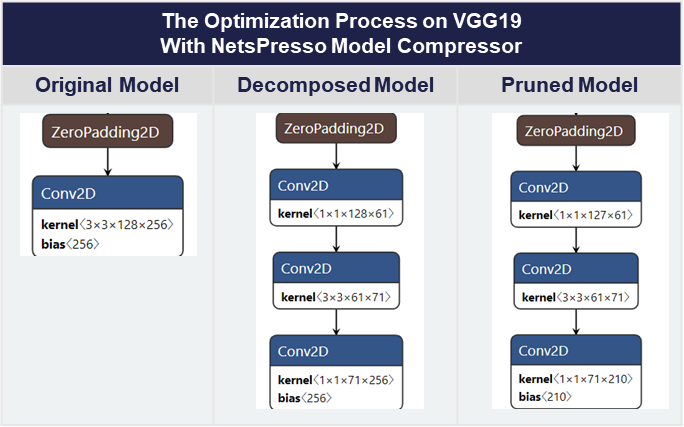

</div>
<div align='center'>
Fig. 3 The optimization process for a single convolutional neural network in VGG19 with NetsPresso Model Compressor

 <!-- - Original model, decomposed model, and pruned model (from left to right). -->
</div>


<a name="acc"></a>
### Accuracy comparision

In [ ]:
original_model.compile(            
    optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum = 0.9),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = "CategoricalAccuracy",)

original_model_accuracy = original_model.evaluate(x=test_loader)[1]*100
compressed_model_accuracy = compressed_model.evaluate(x=test_loader)[1]*100

print("--- Original model ==> Compressed model ---")
print(f"Accuracy: {round(original_model_accuracy,3)}% ==> {round(compressed_model_accuracy,3)}%")

<a name="flopsParams"></a>
### FLOPs & Parameters comparision

In [ ]:
from keras_flops import get_flops 

def get_params(model):
    trainable_params = np.sum([np.prod(v.get_shape()) for v in model.trainable_weights])
    non_trainable_params = np.sum([np.prod(v.get_shape()) for v in model.non_trainable_weights])
    return trainable_params + non_trainable_params

original_params = get_params(original_model)/1e6
compressed_params = get_params(compressed_model)/1e6

original_flops = get_flops(original_model,batch_size=1) /1e6
compressed_flops = get_flops(compressed_model,batch_size=1)/1e6

print("\n--- Original model ==> Compressed model ---")
print(f"FLOPs: {round(original_flops,3)}M ==> {round(compressed_flops,3)}M (x{round(original_flops/compressed_flops,3)})")
print(f"Params: {round(original_params,3)}M ==> {round(compressed_params,3)}M (x{round(original_params/compressed_params,3)})")

<a name="latency"></a>
### Latency comparision

In [ ]:
original_tflite_model = tf.lite.TFLiteConverter.from_keras_model(original_model).convert()
compressed_tflite_model = tf.lite.TFLiteConverter.from_keras_model(compressed_model).convert()

with open('original_model.tflite','wb') as f:
    f.write(original_tflite_model)
with open('compressed_model.tflite','wb') as f:
    f.write(compressed_tflite_model)

In [ ]:
import numpy as np
import time
def get_latency(model_path,run_times=100):
  
  interpreter = tf.lite.Interpreter(model_path=model_path)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  input_shape = input_details[0]['shape']
  input_data = np.array(np.random.random_sample(input_shape),dtype=np.float32)
  interpreter.set_tensor(input_details[0]['index'],input_data)

  latency = []
  for _ in range(run_times):

    stime=time.perf_counter()
    interpreter.invoke()
    etime=time.perf_counter()

    latency.append(etime-stime)

  # remove warm up time
  latency.pop(0)
  return sum(latency)/len(latency)* 1000 

In [ ]:
original_latency = get_latency('original_model.tflite',run_times=100)
compressed_latency = get_latency('compressed_model.tflite',run_times=100)

print("Original Model ==> Compressed Model")
print(f"Latency: {round(original_latency,3)}ms ==> {round(compressed_latency,3)}ms (x{round(original_latency/compressed_latency,3)})")

<a name="layerShape"></a>

### Architecture of the compressed model

In [ ]:
compressed_model.summary()